# Phase 2 : Implémentation de base

### Importation bibliotheques

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import roberts, sobel
from skimage import img_as_ubyte
from scipy.signal import find_peaks

### Charger l'image et la convertir en niveaux de gris

In [29]:
def load_and_convert_to_gray(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Erreur : Impossible de charger l'image '{image_path}'. Vérifiez le chemin.")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray

### Calculer l'histogramme

In [30]:
def compute_histogram(gray_image):
    hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    return hist

### Détecter les plages d'intensité

In [31]:
def detect_intensity_ranges(hist, threshold=50):
    peaks, _ = find_peaks(hist.squeeze(), height=threshold, distance=50)
    if len(peaks) >= 2:
        return [(peaks[0], peaks[1]), (peaks[1] + 1, peaks[-1])]
    return [(0, 127), (128, 255)]

### Générer des masques

In [32]:
def generate_masks(gray_image, threshold_ranges):
    masks = [(gray_image >= low) & (gray_image <= high) for (low, high) in threshold_ranges]
    return [mask.astype(np.uint8) * 255 for mask in masks]

### Appliquer l'algorithme de contour actif

In [33]:
def apply_active_contour(gray_image, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.zeros_like(gray_image)
    cv2.drawContours(contour_img, contours, -1, 255, 2)
    return contour_img

### Appliquer les opérateurs de détection des bords

In [34]:
def apply_edge_detection(image):
    edges_canny = cv2.Canny(image, 50, 150)
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    _, edges_laplacian = cv2.threshold(laplacian, 50, 255, cv2.THRESH_BINARY)
    edges_roberts = img_as_ubyte(roberts(image))
    return edges_canny, edges_laplacian, edges_roberts

### Orchestrer le processus avec la fonction principale

In [35]:
def main(image_path):
    image, gray = load_and_convert_to_gray(image_path)
    hist = compute_histogram(gray)
    threshold_ranges = detect_intensity_ranges(hist)
    masks = generate_masks(gray, threshold_ranges)
    
    active_contours = [apply_active_contour(gray, mask) for mask in masks]
    edges = [apply_edge_detection(ac) for ac in active_contours]

    # Affichage des résultats (détaillé dans le code original)
    plt.figure(figsize=(12, 8))
    plt.subplot(231), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Image originale')
    plt.subplot(232), plt.imshow(gray, cmap='gray'), plt.title('Niveaux de gris')
    plt.subplot(233), plt.plot(hist), plt.title('Histogramme')
    for i, mask in enumerate(masks):
        plt.subplot(234 + i), plt.imshow(mask, cmap='gray'), plt.title(f'Masque {i+1}')
    plt.show()

    plt.figure(figsize=(12, 6))
    for i, ac in enumerate(active_contours):
        plt.subplot(1, len(active_contours), i + 1)
        plt.imshow(ac, cmap='gray')
        plt.title(f'Contours actifs {i+1}')
    plt.show()

    edge_titles = ['Canny', 'Laplacian', 'Roberts']
    for i, edge_set in enumerate(edges):
        plt.figure(figsize=(20, 15))
        for j, edge in enumerate(edge_set):
            plt.subplot(1, 3, j + 1)
            plt.imshow(edge, cmap='gray')
            plt.title(f'{edge_titles[j]} - Région {i+1}')
        plt.show()

    return edges

### Exemple d'utilisation

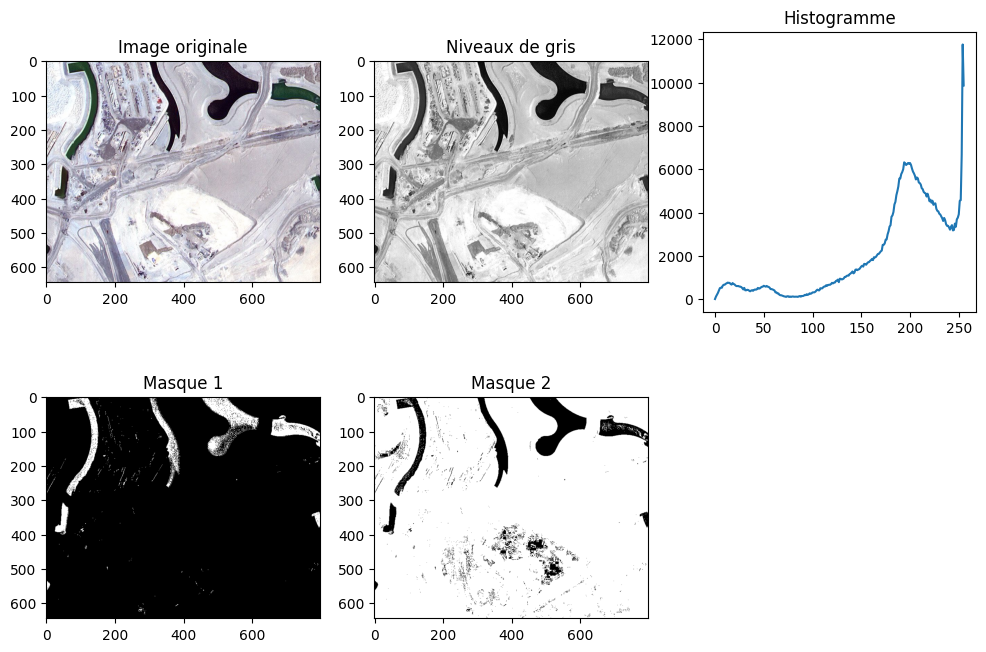

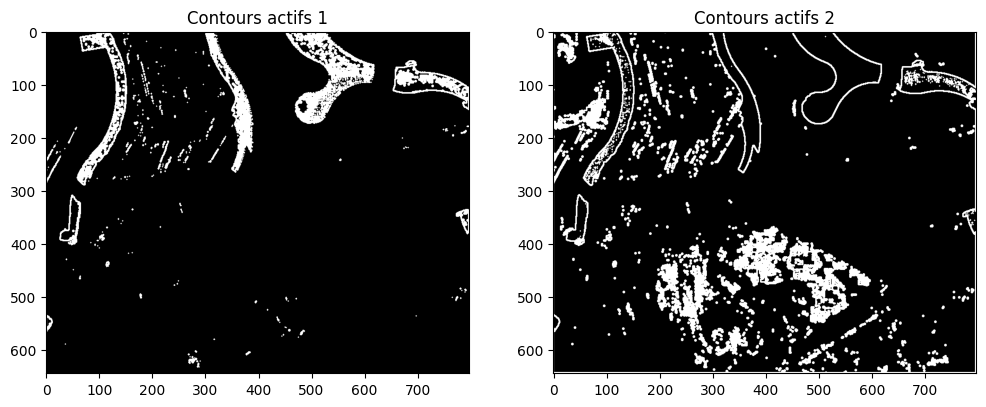

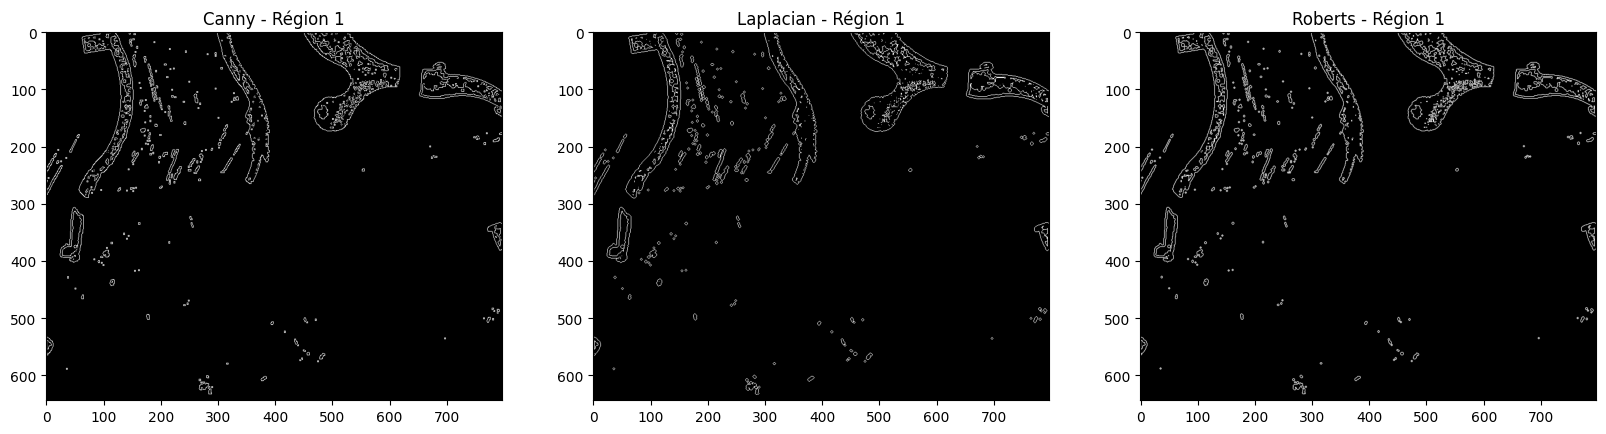

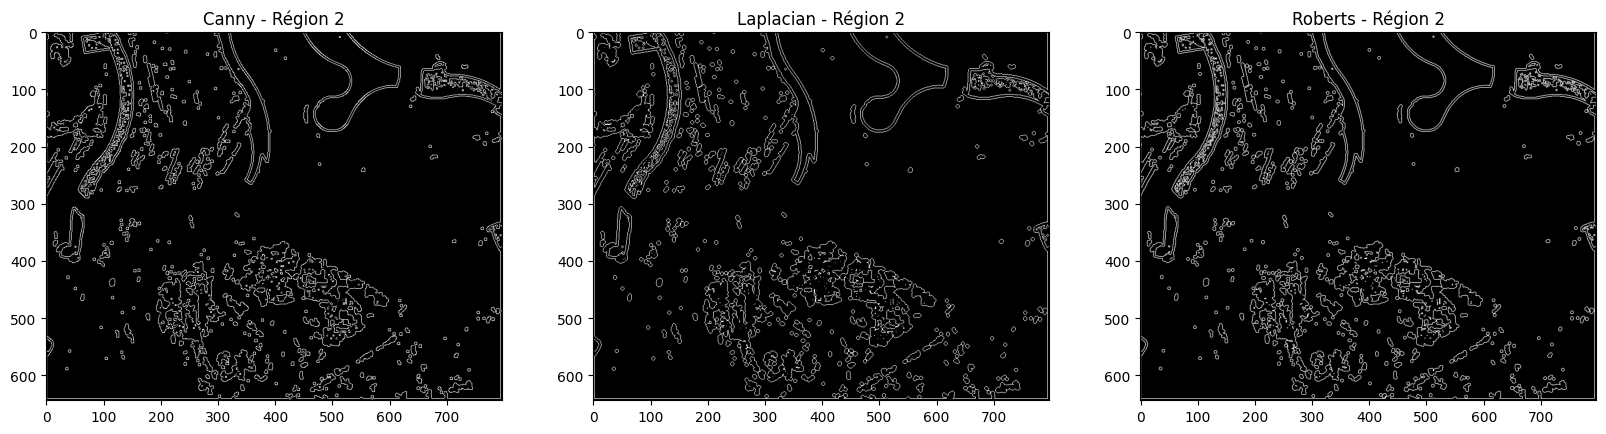

In [36]:
generated_edges = main('Semantic segmentation dataset/Tile 1/images/image_part_001.jpg')

# Phase 3 : Proposition et Évaluation d'Améliorations

## Partie 1 : Utilisation d'autres algorithmes de segmentation ---

### Importation des bibliothèques

In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

### Fonction de chargement de l'image

In [59]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Erreur : Impossible de charger l'image '{image_path}'")
    return image

### Conversion en niveaux de gris

In [60]:
def rgb_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

### Seuillage d'Otsu

In [68]:
def otsu_threshold(gray):
    start_time = time.time()
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elapsed_time = time.time() - start_time
    print(f"Seuil d'Otsu calculé: {ret}")
    print(f"Temps de traitement (Seuillage Otsu) : {elapsed_time:.4f} secondes")
    return thresh

### Segmentation par Watershed

In [62]:
def watershed_segmentation(image, thresh):
    start_time = time.time()
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image, markers)
    watershed_image = image.copy()
    watershed_image[markers == -1] = [255, 0, 0]
    elapsed_time = time.time() - start_time
    print(f"Temps de traitement (Sgmentation par Watershed) : {elapsed_time:.4f} secondes")
    return markers, watershed_image

### Segmentation par k-means

In [63]:
def kmeans_segmentation(image, K=3):
    start_time = time.time()
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    ret, labels, centers = cv2.kmeans(pixel_values, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    segmented_image = segmented_data.reshape(image.shape)
    elapsed_time = time.time() - start_time
    print(f"Temps de traitement (Segmentation par k-means) : {elapsed_time:.4f} secondes")
    return segmented_image

### Affichage des résultats

In [73]:
def plot_results(original, gray, otsu_img, markers, watershed_img, kmeans_img):
    plt.figure(figsize=(15, 10))
    plt.subplot(231)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Image originale")
    plt.subplot(232)
    plt.imshow(gray, cmap='gray')
    plt.title("Niveaux de gris")
    plt.subplot(233)
    plt.imshow(otsu_img, cmap='gray')
    plt.title("Seuillage Otsu")
    plt.subplot(234)
    plt.imshow(cv2.cvtColor(watershed_img, cv2.COLOR_BGR2RGB))
    plt.title("Segmentation Watershed")
    plt.subplot(235)
    plt.imshow(cv2.cvtColor(kmeans_img, cv2.COLOR_BGR2RGB))
    plt.title("Segmentation K-means")
    plt.tight_layout()
    plt.show()

### Fonction principale

In [74]:
def main(image_path):
    image = load_image(image_path)
    gray = rgb_to_gray(image)
    otsu_img = otsu_threshold(gray)
    markers, watershed_img = watershed_segmentation(image.copy(), otsu_img)
    kmeans_img = kmeans_segmentation(image, K=3)
    plot_results(image, gray, otsu_img, markers, watershed_img, kmeans_img)

### Exécution du script

Seuil d'Otsu calculé: 143.0
Temps de traitement (Seuillage Otsu) : 0.0010 secondes
Temps de traitement (Sgmentation par Watershed) : 0.1055 secondes
Temps de traitement (Segmentation par k-means) : 2.6725 secondes


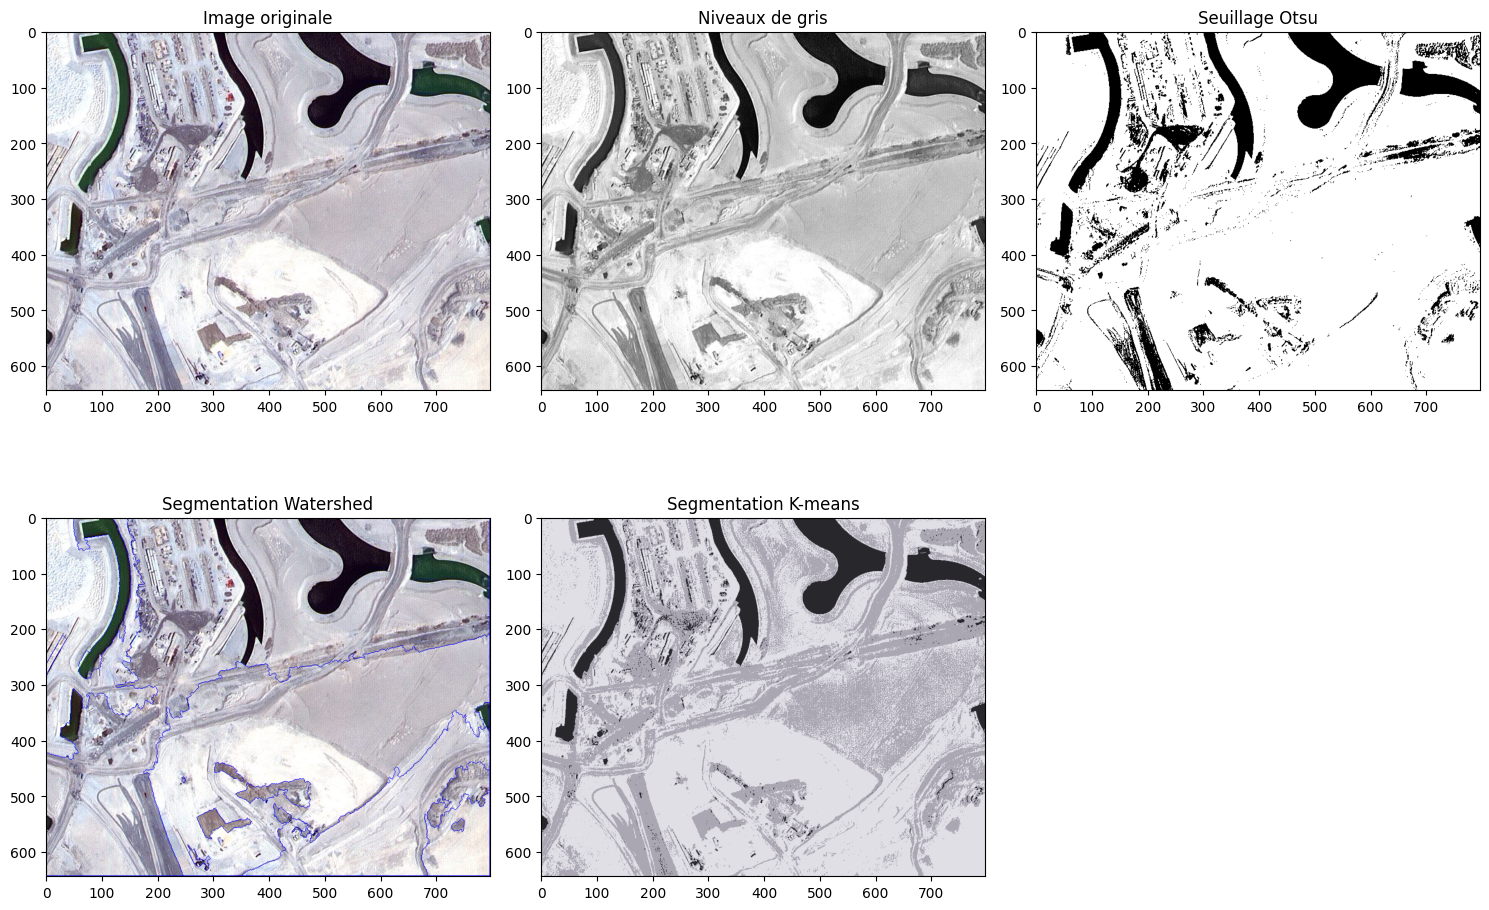

In [75]:
if __name__ == '__main__':
    main('Semantic segmentation dataset/Tile 1/images/image_part_001.jpg')

## Partie 2 : Test avec des masques différents pour l’algorithme de contours actifs ---

### Charger l'image en niveaux de gris

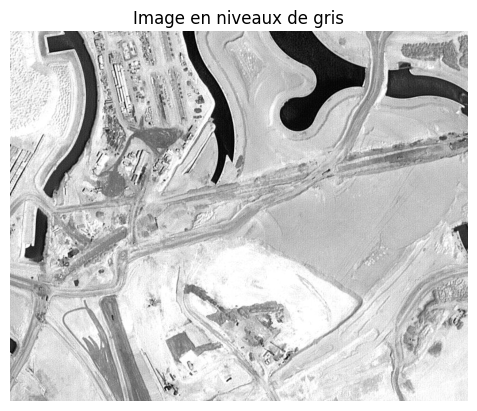

In [76]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(image_path):
    """
    Charge une image et la convertit en niveaux de gris.
    """
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray

# Exemple d'utilisation
image_path = "Semantic segmentation dataset/Tile 1/images/image_part_001.jpg"  # Remplace par ton chemin d'image
image, gray = load_image(image_path)

# Afficher l'image en niveaux de gris
plt.imshow(gray, cmap='gray')
plt.title("Image en niveaux de gris")
plt.axis('off')
plt.show()


### Générer les masques de seuillage

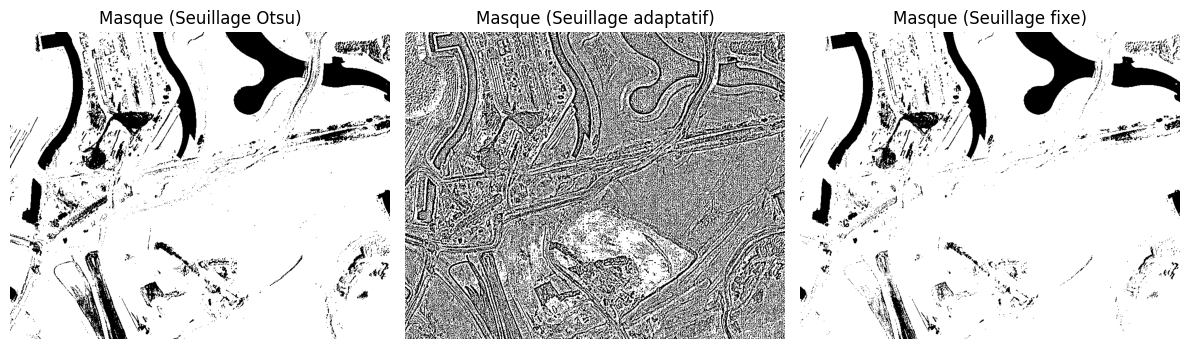

In [77]:
def segmentation_otsu(gray):
    """
    Applique le seuillage d'Otsu pour générer un masque.
    """
    _, mask_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask_otsu

def generate_masks_differents(gray):
    """
    Génère trois types de masques : Otsu, adaptatif et fixe.
    """
    mask_otsu = segmentation_otsu(gray)
    mask_adaptatif = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                           cv2.THRESH_BINARY, 11, 2)
    _, mask_fixe = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    return mask_otsu, mask_adaptatif, mask_fixe

# Générer les masques
masks = generate_masks_differents(gray)
titres = ['Seuillage Otsu', 'Seuillage adaptatif', 'Seuillage fixe']

# Afficher les masques
plt.figure(figsize=(12, 4))
for i, m in enumerate(masks):
    plt.subplot(1, 3, i + 1)
    plt.imshow(m, cmap='gray')
    plt.title(f'Masque ({titres[i]})')
    plt.axis('off')
plt.tight_layout()
plt.show()


### Appliquer l’algorithme de contours actifs

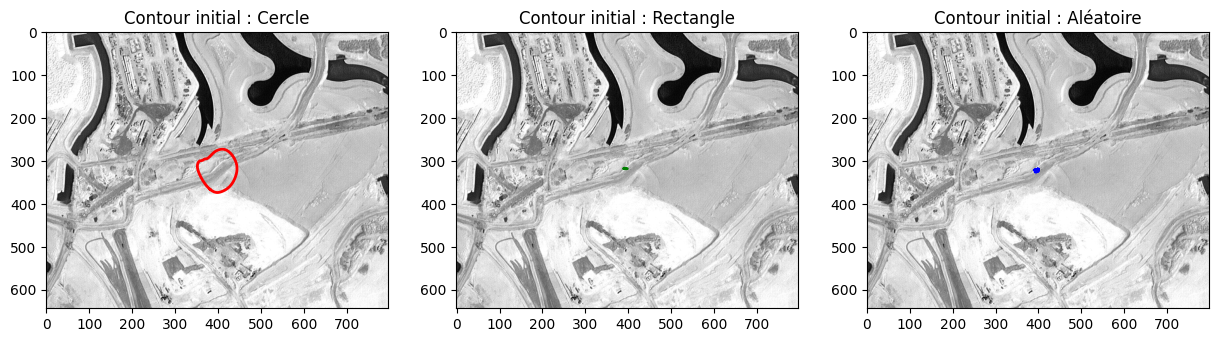

In [116]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import color, io
from skimage.filters import gaussian
from skimage.segmentation import active_contour

# Charger l'image
image = cv2.imread("Semantic segmentation dataset/Tile 1/images/image_part_001.jpg", cv2.IMREAD_GRAYSCALE)

# Appliquer un léger flou pour améliorer la détection des contours
image_smooth = gaussian(image, sigma=2)

# Définition de différents masques initiaux
h, w = image.shape

# 1. Masque circulaire au centre
t = np.linspace(0, 2*np.pi, 400)
x_circle = h//2 + 50 * np.cos(t)
y_circle = w//2 + 50 * np.sin(t)
init_circle = np.array([x_circle, y_circle]).T

# 2. Masque rectangulaire
x_rect = np.array([h//3, h//3, 2*h//3, 2*h//3, h//3])
y_rect = np.array([w//3, 2*w//3, 2*w//3, w//3, w//3])
init_rect = np.array([x_rect, y_rect]).T

# 3. Masque aléatoire
np.random.seed(42)
x_random = np.random.randint(h//3, 2*h//3, 100)
y_random = np.random.randint(w//3, 2*w//3, 100)
init_random = np.array([x_random, y_random]).T

# Appliquer Active Contours (Snakes) pour chaque masque
snake_circle = active_contour(image_smooth, init_circle, alpha=0.015, beta=10, gamma=0.001)
snake_rect = active_contour(image_smooth, init_rect, alpha=0.015, beta=10, gamma=0.001)
snake_random = active_contour(image_smooth, init_random, alpha=0.015, beta=10, gamma=0.001)

# Affichage des résultats
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image, cmap='gray')
ax[0].plot(snake_circle[:, 1], snake_circle[:, 0], '-r', lw=2)
ax[0].set_title("Contour initial : Cercle")

ax[1].imshow(image, cmap='gray')
ax[1].plot(snake_rect[:, 1], snake_rect[:, 0], '-g', lw=2)
ax[1].set_title("Contour initial : Rectangle")

ax[2].imshow(image, cmap='gray')
ax[2].plot(snake_random[:, 1], snake_random[:, 0], '-b', lw=2)
ax[2].set_title("Contour initial : Aléatoire")

plt.show()


### Partie 3 : Comparaison avec d’autres techniques de détection de contours

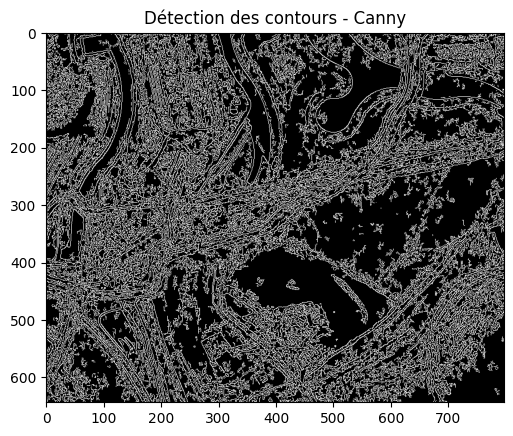

In [117]:
edges = cv2.Canny(image, 50, 150)

plt.imshow(edges, cmap='gray')
plt.title("Détection des contours - Canny")
plt.show()


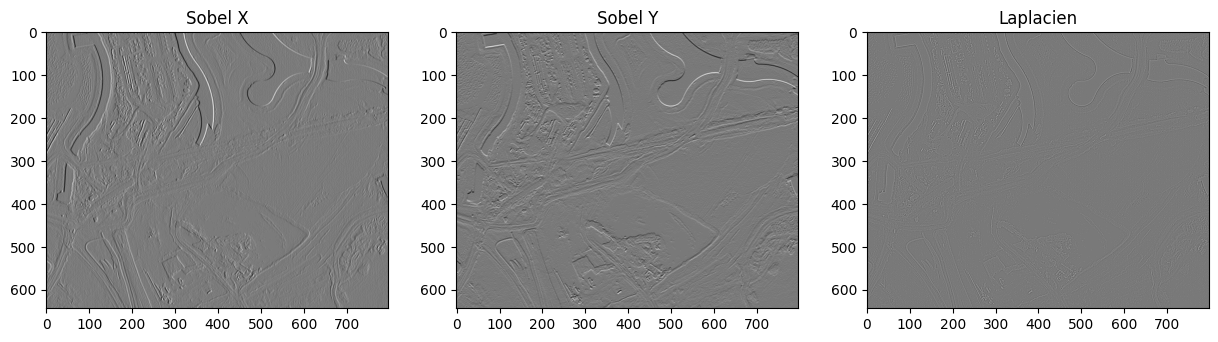

In [118]:
sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
laplacian = cv2.Laplacian(image, cv2.CV_64F)

# Affichage
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(sobelx, cmap='gray'); ax[0].set_title("Sobel X")
ax[1].imshow(sobely, cmap='gray'); ax[1].set_title("Sobel Y")
ax[2].imshow(laplacian, cmap='gray'); ax[2].set_title("Laplacien")
plt.show()
